In [158]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [159]:
DATA_PATH = ''
#HISTORY_PATH = "Voter_History_{0}"
PREPROCESSED_PATH = "preprocessed/{0}/florida_processed_{0}.csv"
COUPLES_PATH="couples/{0}/couples_{0}.csv"
#COUPLES_PATH="couples/{0}/couples_FLA_{0}.csv"

In [160]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--old', dest='old_date', action='store', type=str, help='old date value')
parser.add_argument('--new', dest='new_date', action='store', type=str, help='new date value')

args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--old OLD_DATE] [--new NEW_DATE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/rahullachh/.local/share/jupyter/runtime/kernel-9717e402-a4a6-40ec-8da8-cefb52b7cb35.json


SystemExit: 2

In [161]:
#preprocessed_date = args.new_date
preprocessed_date = str(20190910)

In [162]:
#couples_date = args.old_date
couples_date = str(20140319)

In [163]:
image_file_prefix = couples_date + "_" + preprocessed_date
stat_file_prefix =  couples_date + "_" + preprocessed_date

import os
if not os.path.exists("plots/" + image_file_prefix):
    os.makedirs("plots/" + image_file_prefix)

if not os.path.exists("stats/" + stat_file_prefix):
    os.makedirs("stats/" + stat_file_prefix)
    
stat_file_path = "stats/" + stat_file_prefix + "/"

In [164]:
global_df = pd.read_csv(PREPROCESSED_PATH.format(preprocessed_date) , sep='\t')

In [174]:
#global_df.residence_zipcode_5.unique().shape
zip_df = pd.read_csv("us-zipcode.csv" , sep=';')

In [175]:
zip_df.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,33446,Delray Beach,FL,26.452473,-80.165090,-5,1,"26.452473,-80.16509"
1,32621,Bronson,FL,29.447069,-82.604520,-5,1,"29.447069,-82.60452"
2,34447,Homosassa Springs,FL,28.804911,-82.574264,-5,1,"28.804911,-82.574264"
3,34489,Silver Springs,FL,29.215153,-82.097163,-5,1,"29.215153,-82.097163"
4,32503,Pensacola,FL,30.447997,-87.207270,-6,1,"30.447997,-87.20727"


In [258]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,...,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr,Zip,Latitude,Longitude,geopoint,race_desc
0,ALA,100419592,martin,william,3814 nw 266th st,NaN,newberry,32669,M,5,...,ACT,47,32669,NaN,3814 nw 266th st newberry 32669,32669,29.640613,-82.59446,"29.640613,-82.59446",White
1,ALA,102183223,mulaiya,doodnauth,2296 nw 147th st,NaN,newberry,32669,M,2,...,ACT,78,32669,NaN,2296 nw 147th st newberry 32669,32669,29.640613,-82.59446,"29.640613,-82.59446",Asian/Pacific Islander
2,ALA,100518300,stowers,gary,25427 sw 16th ave,NaN,newberry,32669,M,5,...,ACT,70,32669,NaN,25427 sw 16th ave newberry 32669,32669,29.640613,-82.59446,"29.640613,-82.59446",White
3,ALA,100576200,carrasquillo,alberto,25746 nw 5th ave,NaN,newberry,32669,M,4,...,ACT,55,32669,NaN,25746 nw 5th ave newberry 32669,32669,29.640613,-82.59446,"29.640613,-82.59446",Hispanic
4,ALA,100443200,rezaei,saima,13616 sw 4th ln,NaN,newberry,32669,F,5,...,ACT,52,32669,NaN,13616 sw 4th ln newberry 32669,32669,29.640613,-82.59446,"29.640613,-82.59446",White


In [ ]:
zip_df_ = zip_df[['Zip','Latitude','Longitude','geopoint']]
global_df = pd.merge(global_df, zip_df_, left_on=["residence_zipcode"], right_on=["Zip"])

In [177]:
req_cols = ['last_name', 'race', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [178]:
global_df.isnull().sum()

county_code                     0
voter_id                        0
last_name                       0
first_name                      0
residence_addr_line_1           0
residence_addr_line_2    11496956
residence_city                  0
residence_zipcode               0
gender                          0
race                            0
birth_date                      0
registration_date               0
party_affiliation               0
precinct                        0
voter_status                    0
age                             0
residence_zipcode_5             0
residence_zipcode_4      12037566
uniq_addr                       0
dtype: int64

In [179]:
global_df.shape

(14125318, 19)

In [194]:
couples_df = pd.read_csv(COUPLES_PATH.format(couples_date) , sep='\t')

In [195]:
couples_df[["uniq_addr"]].head()

,uniq_addr
0,1 clay county grn cv spgs 32043
1,4923 adra ct fleming island 32003
2,2332 birdwood dr orange park 32073
3,3016 alpaca ave middleburg 32068
4,6653 immokalee rd keystone heights 32656


In [205]:
addr_df = global_df[["voter_id","uniq_addr","Latitude","Longitude"]]

## Collecting Addresses of voters

In [206]:
couples_df_found = pd.merge(couples_df, addr_df, left_on=["voter_id_L"], right_on=["voter_id"], suffixes=["","_L"])

In [207]:
del couples_df_found['voter_id']

In [208]:
couples_df_found = pd.merge(couples_df_found, addr_df, left_on=["voter_id_R"], right_on=["voter_id"], suffixes=["","_R"])

Merging Lat Long

In [260]:
couples_df_found.columns

Index(['county_code_L', 'voter_id_L', 'last_name_L', 'first_name_L',
       'residence_addr_line_1_L', 'residence_addr_line_2_L',
       'residence_city_L', 'residence_zipcode_L', 'gender_L', 'race_L',
       'birth_date_L', 'registration_date_L', 'party_affiliation_L',
       'precinct_L', 'voter_status_L', 'age_L', 'residence_zipcode_5_L',
       'residence_zipcode_4_L', 'uniq_addr', 'county_code_R', 'voter_id_R',
       'last_name_R', 'first_name_R', 'residence_addr_line_1_R',
       'residence_addr_line_2_R', 'residence_city_R', 'residence_zipcode_R',
       'gender_R', 'race_R', 'birth_date_R', 'registration_date_R',
       'party_affiliation_R', 'precinct_R', 'voter_status_R', 'age_R',
       'residence_zipcode_5_R', 'residence_zipcode_4_R', 'age_diff',
       'uniq_addr_L', 'Latitude', 'Longitude', 'uniq_addr_R', 'Latitude_R',
       'Longitude_R', 'separated', 'race_desc_L', 'race_desc_R'],
      dtype='object')

### Removing extra column generated of voter id

In [209]:
del couples_df_found['voter_id']

In [210]:
couples_df_found[["voter_id_L","voter_id_R", "uniq_addr_L","uniq_addr_R"]].head()

,voter_id_L,voter_id_R,uniq_addr_L,uniq_addr_R
0,102842993,102860174,554 oakmont dr orange park 32073,554 oakmont dr orange park 32073
1,102845812,102851128,2672 holly point rd w orange park 32073,2672 holly point rd w orange park 32073
2,102842958,102880507,962 sweetwood ct orange park 32065,962 sweetwood ct orange park 32065
3,102843200,102843421,3060 tower oaks dr orange park 32065,3060 tower oaks dr orange park 32065
4,102844398,102844399,1571 glen view st middleburg 32068,1571 glen view st middleburg 32068


In [211]:
couples_df_found['separated'] = couples_df_found.apply(lambda x : x.uniq_addr_L != x.uniq_addr_R, axis=1)

## Separation percentage

In [212]:
couples_df_found['separated'].value_counts()

False    1416170
True      271468
Name: separated, dtype: int64

In [213]:
couples_df_found['separated'].value_counts()/couples_df_found['separated'].shape

False    0.839143
True     0.160857
Name: separated, dtype: float64

In [143]:
global_df['uniq_addr'].unique().shape

(7455943,)

In [214]:
couples_df_found.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,residence_zipcode_5_R,residence_zipcode_4_R,age_diff,uniq_addr_L,Latitude,Longitude,uniq_addr_R,Latitude_R,Longitude_R,separated
0,CLA,102842993,motolenich,stephen,554 oakmont dr,NaN,orange park,32073,M,4.0,...,32073,NaN,0,554 oakmont dr orange park 32073,30.160965,-81.72916,554 oakmont dr orange park 32073,30.160965,-81.72916,False
1,CLA,102845812,young,kirk,2672 holly point rd w,NaN,orange park,32073,M,5.0,...,32073,NaN,0,2672 holly point rd w orange park 32073,30.160965,-81.72916,2672 holly point rd w orange park 32073,30.160965,-81.72916,False
2,CLA,102842958,wall,james,962 sweetwood ct,NaN,orange park,32065,M,5.0,...,32065,NaN,0,962 sweetwood ct orange park 32065,30.133007,-81.77904,962 sweetwood ct orange park 32065,30.133007,-81.77904,False
3,CLA,102843200,wilkening,harold,1828 lakedge dr,NaN,middleburg,320686620,M,5.0,...,32068,6620.0,0,3060 tower oaks dr orange park 32065,30.133007,-81.77904,3060 tower oaks dr orange park 32065,30.133007,-81.77904,False
4,CLA,102844398,pappas,attis,1571 glen view st,NaN,middleburg,32068,F,5.0,...,32068,NaN,0,1571 glen view st middleburg 32068,30.074926,-81.87932,1571 glen view st middleburg 32068,30.074926,-81.87932,False


## Logging total separation percentage in file

In [261]:
total_separated_couples = couples_df_found[couples_df_found["separated"] == True].shape[0]
with open(stat_file_path + "total_separation_percentage.csv", "w") as f:
    f.write("\t".join(["separated_count", "total_count", "percentage"]) + "\n")
    f.write("\t".join([str(total_separated_couples), str(couples_df_found.shape[0]), str(100.0 * total_separated_couples/couples_df_found.shape[0])]))

## Convert race categorical 

In [262]:
race_codes = {
    1: "American Indian/Alaskan Native",
    2: "Asian/Pacific Islander",
    3: "Black/Not Hispanic",
    4: "Hispanic",
    5: "White",
    6: "Other",
    7: "Mutli-racial",
    9: "Unknown"
}

## Converting race codes to corresponding race-descriptions

In [263]:
def race_code_lambda(row, subscript):
    if pd.isnull(row["race_" + subscript]):
        return None
    code = int(row["race_" + subscript])
    return race_codes[code]

## Creating descriptive race columns is a time consuming process

In [264]:
couples_df_found["race_desc_L"] = couples_df_found.apply(lambda x: race_code_lambda(x, "L"), axis=1)
couples_df_found["race_desc_R"] = couples_df_found.apply(lambda x: race_code_lambda(x, "R"), axis=1)

In [265]:
global_df["race_desc"] = global_df["race"].apply(lambda x: race_codes[x])

## Feature wise separation percentage

In [266]:
cols = ["party_affiliation", "gender", "race_desc"]
unique_dic = {}
for c in cols:
    unique_dic[c] = set(global_df[c].unique())

## Demographic Percentages

In [267]:
party_affiliation_counts = {}
race_counts = {}

party_affiliation_percentages = {}
race_percentages = {}

total = global_df.shape[0]
for cat_value in unique_dic["party_affiliation"]:
    party_affiliation_counts[cat_value] = global_df[global_df["party_affiliation"] == cat_value].shape[0]
    party_affiliation_percentages[cat_value] = 100.0 * global_df[global_df["party_affiliation"] == cat_value].shape[0]/total

for cat_value in unique_dic["race_desc"]:
    race_counts[str(cat_value)] = global_df[global_df["race_desc"] == cat_value].shape[0]
    race_percentages[str(cat_value)] =  100.0 * global_df[global_df["race_desc"] == cat_value].shape[0]/total

## Thresholding Demographics
For Race we stick to 5% </br>
For Party affiliation we stick to 5%

In [268]:
race_percent_threshold = 5.0
race_other_groups = []
for cat_value in race_percentages:
    if race_percentages[cat_value] <= race_percent_threshold:
        race_other_groups.append(cat_value)

In [269]:
party_percent_threshold = 5.0
party_other_groups = []
for cat_value in party_affiliation_percentages:
    if party_affiliation_percentages[cat_value] <= party_percent_threshold:
        party_other_groups.append(cat_value)

# TODO

In [270]:
# TODO: Implement others mapping into global and couples dataframe
# def create_others_df()

In [271]:
global_df.shape

(11800473, 24)

In [272]:
print(str(unique_dic))

{'party_affiliation': {'CPF', 'DEM', 'REF', 'ECO', 'PSL', 'NPA', 'LPF', 'IND', 'REP', 'GRE'}, 'gender': {'M', 'F', 'U'}, 'race_desc': {'Black/Not Hispanic', 'Asian/Pacific Islander', 'Other', 'Unknown', 'American Indian/Alaskan Native', 'White', 'Hispanic', 'Mutli-racial'}}


## Generate Pair-wise stats by feature
Current focus is only on gender/race/political-affiliation

In [273]:
import time
from itertools import combinations 

def generate_category_based_on_pair_values(first_val, second_val):
    return "({0}, {1})".format(str(first_val), str(second_val))

def generate_pair_stats_by_feature(global_df, couples_df_found, feature, stats={}, others=[]):
    print("Collecting uniques by feature: " + feature)
    unique_vals = list(global_df[feature].unique())
    cat_combinations = list(combinations(list(unique_vals), 2))
    
    stats[feature] = {}
    print("Processing : " + feature + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    start_time = time.time()
    stats[feature]["Other Categories"] = {'count': 0, 'total': 0}
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[feature + "_L"] == first_val) & (couples_df_found[feature + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[feature + "_L"] == second_val) & (couples_df_found[feature + "_R"] == first_val)]
        
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        if first_val in others or second_val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += left_right.shape[0] + right_left.shape[0]
            continue
        
        stat["total"] = left_right.shape[0] + right_left.shape[0]
        stat["percent"] = count * 100.0/(left_right.shape[0] + right_left.shape[0])
        
        category = generate_category_based_on_pair_values(first_val, second_val)
        stats[feature][category] = stat
        
        i += 1
        
    print("Total value combinations process: " + str(i) + " Total time (secs): " + str(time.time() - start_time))
    
    print("Processing symmetric combinations: " + feature + " : Total comb: " + str(len(unique_vals)))
    for val in unique_vals:
        subset = couples_df_found[(couples_df_found[feature + "_L"] == val) & (couples_df_found[feature + "_R"] == val)]
        
        count = subset[subset["separated"] == True].shape[0]
        
        if val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += subset.shape[0]
            continue
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        stat["total"] = subset.shape[0]
        stat["percent"] = count * 100.0/(subset.shape[0])
        
        category = generate_category_based_on_pair_values(val, val)
        stats[feature][category] = stat
        
    if len(others) > 0 and stats[feature]["Other Categories"]["count"] > 0:
        stats[feature]["Other Categories"]["percent"] = 100.0 * stats[feature]["Other Categories"]["count"]/stats[feature]["Other Categories"]["total"]
    else:
        del stats[feature]["Other Categories"]
    
    print("Done with processing feature: " + feature)
    
    return stats

In [274]:
stat_file_path

'stats/20140319_20190910/'

In [275]:
def plot_pairwise_stat_by_feature(feature, stats, total_couples=1):
    feature_stats = stats[feature]
    
    figures, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    
    percent_stats = []
    pair_combinations = []
    totals = []
    
    for pair_comb in feature_stats:
        percent_stats.append(feature_stats[pair_comb]["percent"])
        totals.append(feature_stats[pair_comb]["total"])
        pair_combinations.append(pair_comb)

    plot_df = pd.DataFrame({"percent": percent_stats, "category_combination": pair_combinations, "totals": totals})
    plot_df["category_combination_percentage"] = 100.0*plot_df["totals"]/total_couples
    
    sns.barplot(x="percent", y="category_combination", data=plot_df, ax=axes[0], palette=sns.color_palette("Set2"))
    
    axes[0].set(xlabel="Separation percentage")
    
    #     sns.barplot(x="category_combination_percentage", y="category_combination", palette=sns.color_palette("Set2"), data=plot_df, ax=axes[1])

    #   Pie chart
    labels = pair_combinations
    sizes = plot_df["category_combination_percentage"].tolist()
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=['teal', 'salmon', 'silver', 'lightblue', 'orchid', 'pink', 'lightgreen', 'wheat'])
    axes[1].axis('equal')
    axes[1].set(xlabel="Category percentage out of total couples")
    
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    
    #     axes[0].set_title(feature)
    #     axes[1].set_title(feature + " wise couple proportion")

    #     Writing stats into file
    stat_file_name = feature + "_totalCouples-" + str(total_couples) + ".csv"
    plot_df.to_csv(stat_file_path + stat_file_name, sep="\t")
        
    plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix +  "_pairwise_stat_" + feature)
    plt.tight_layout()

In [276]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "race_desc", others=race_other_groups)

Processing : race_desc : Total comb: 28
Total value combinations process: 3 Total time (secs): 11.497788429260254
Processing symmetric combinations: race_desc : Total comb: 8
Done with processing feature: race_desc


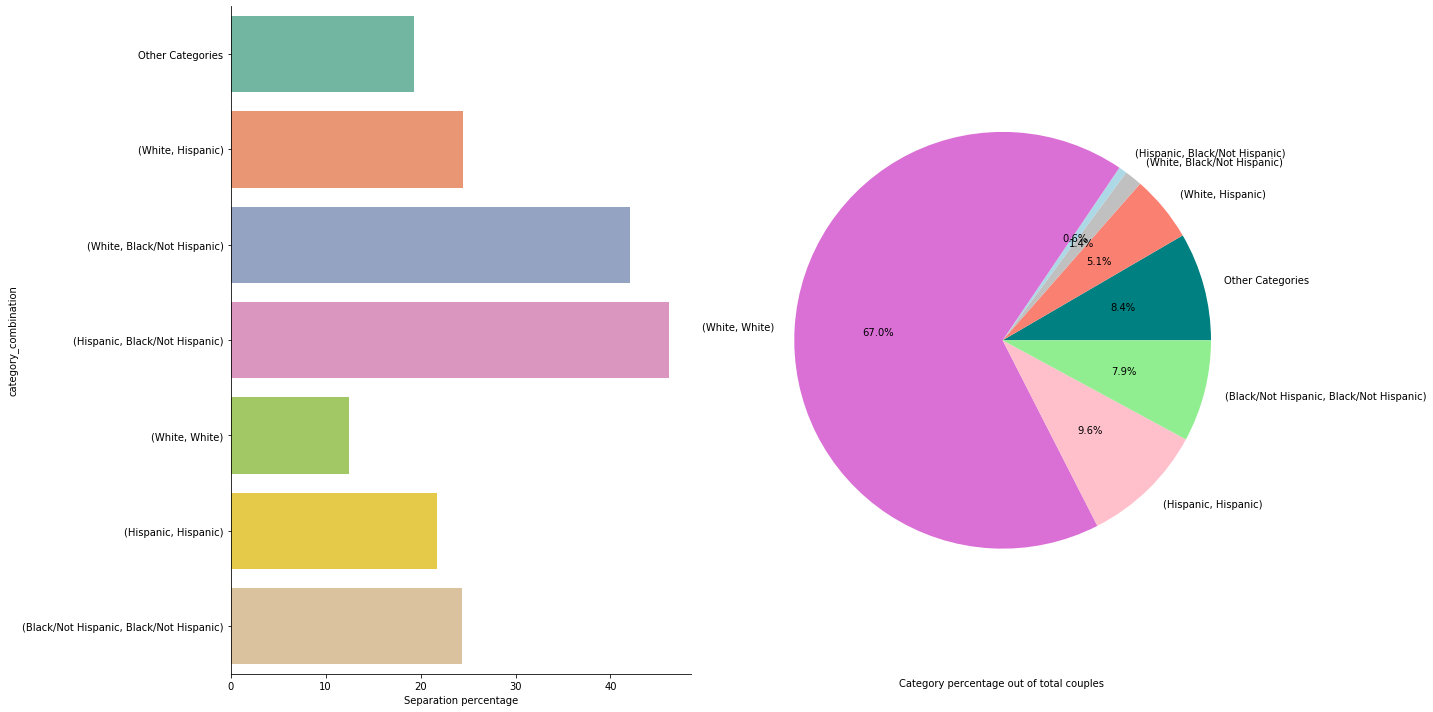

In [277]:
plot_pairwise_stat_by_feature("race_desc", stats, total_couples=couples_df_found.shape[0])

In [278]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "party_affiliation", others=party_other_groups)

Processing : party_affiliation : Total comb: 45
Total value combinations process: 3 Total time (secs): 18.669708967208862
Processing symmetric combinations: party_affiliation : Total comb: 10
Done with processing feature: party_affiliation


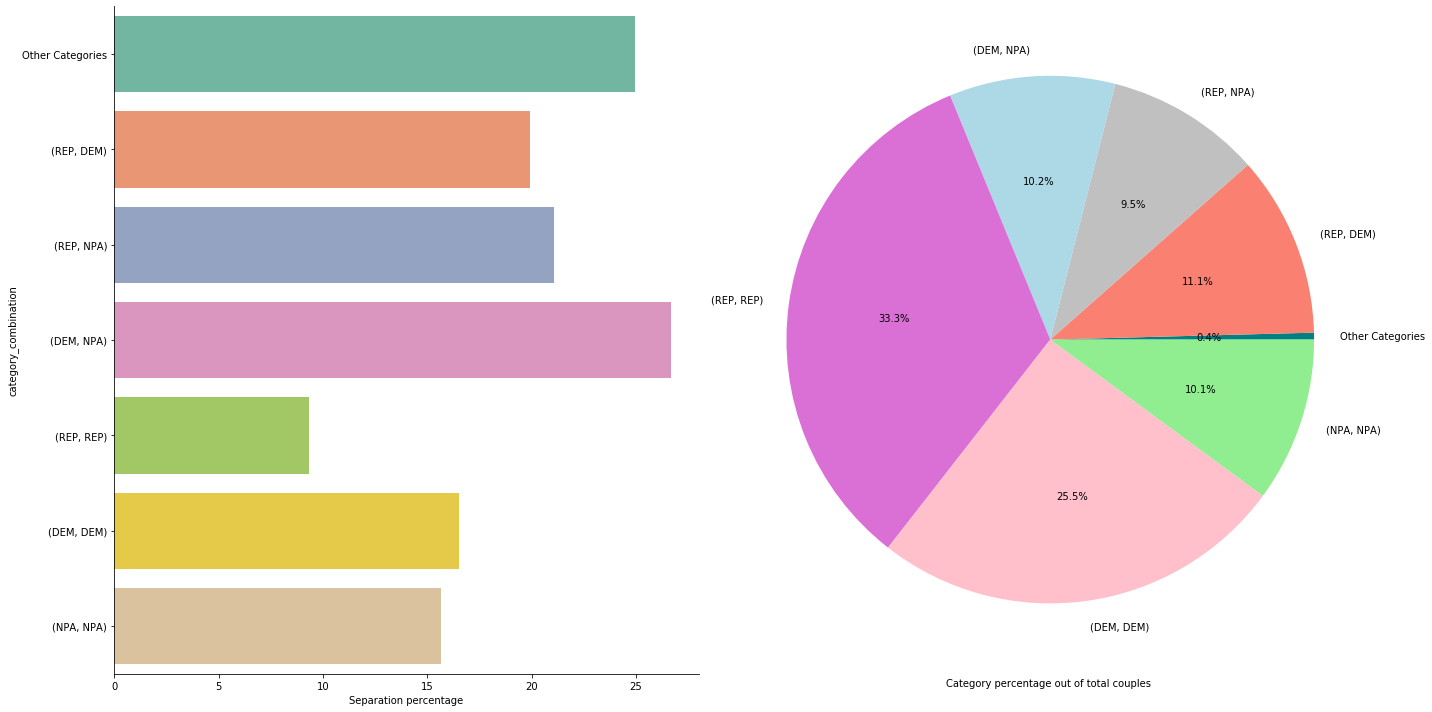

In [279]:
plot_pairwise_stat_by_feature("party_affiliation", stats, total_couples=couples_df_found.shape[0])

In [280]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "gender", others=party_other_groups)

Processing : gender : Total comb: 3
Total value combinations process: 3 Total time (secs): 2.9653148651123047
Processing symmetric combinations: gender : Total comb: 3
Done with processing feature: gender


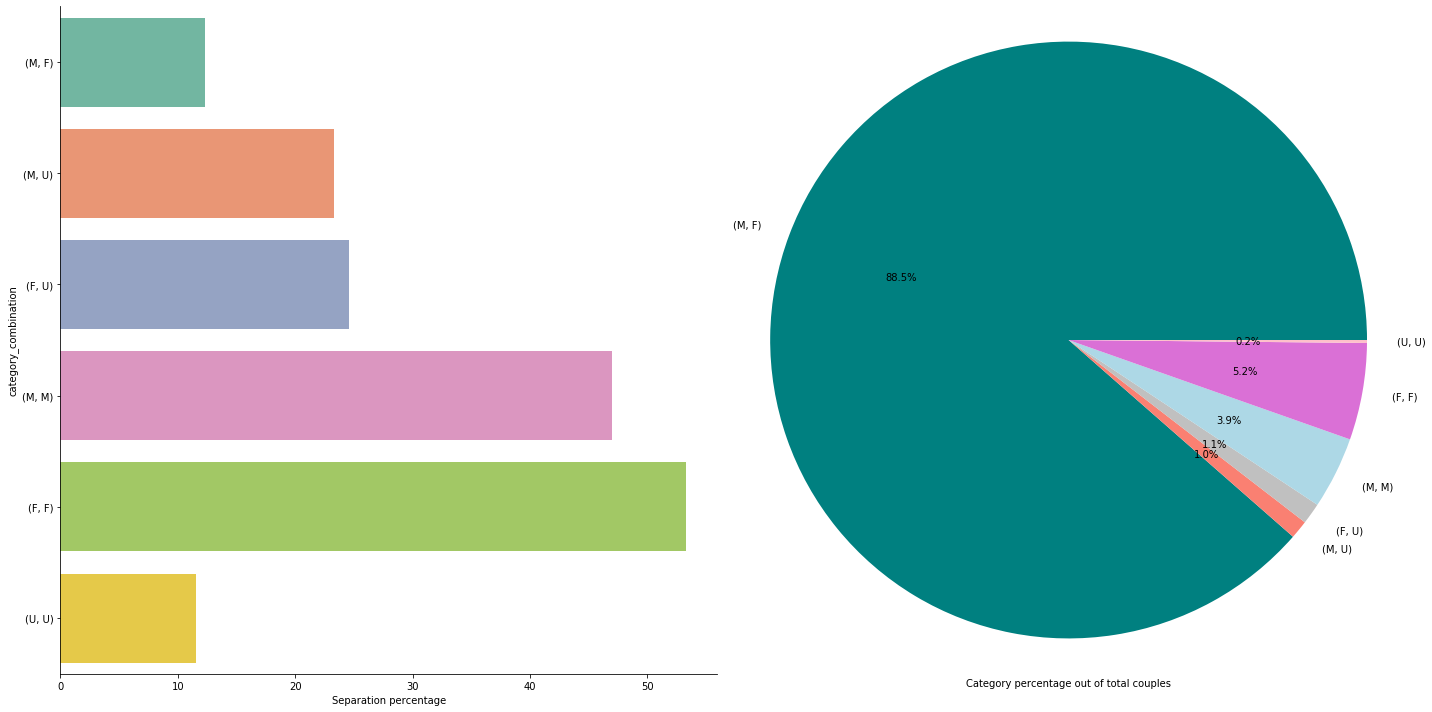

In [281]:
plot_pairwise_stat_by_feature("gender", stats, total_couples=couples_df_found.shape[0])

In [282]:
stats

{'race_desc': {'Other Categories': {'count': 27357,
   'total': 141654,
   'percent': 19.312550298614934},
  '(White, Hispanic)': {'count': 21214,
   'total': 86713,
   'percent': 24.464613149124123},
  '(White, Black/Not Hispanic)': {'count': 9696,
   'total': 23051,
   'percent': 42.0632510520151},
  '(Hispanic, Black/Not Hispanic)': {'count': 4948,
   'total': 10716,
   'percent': 46.173945502053},
  '(White, White)': {'count': 140534,
   'total': 1130295,
   'percent': 12.433391282806701},
  '(Hispanic, Hispanic)': {'count': 35207,
   'total': 161931,
   'percent': 21.741976520863826},
  '(Black/Not Hispanic, Black/Not Hispanic)': {'count': 32489,
   'total': 133191,
   'percent': 24.392789302580503}},
 'party_affiliation': {'Other Categories': {'count': 1666,
   'total': 6675,
   'percent': 24.95880149812734},
  '(REP, DEM)': {'count': 35299,
   'total': 177054,
   'percent': 19.93685542263942},
  '(REP, NPA)': {'count': 31950,
   'total': 151712,
   'percent': 21.059639316599874}

## Raw code of combination stats (Obsolete)

In [283]:
# sns.barplot(x="percent_round", y="category", data=race_df)

In [284]:
couples_df_found.age_diff.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [285]:
age_diff_total_counts = couples_df_found.groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [286]:
age_diff_total_counts.head()

,age_diff,count
0,0,199486
1,1,334827
2,2,266914
3,3,203112
4,4,153817


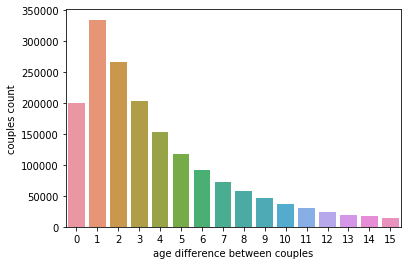

In [287]:
#plt.clear()
plt.close()
ax = sns.barplot(x="age_diff", y="count", data=age_diff_total_counts)
ax.set(xlabel='age difference between couples', ylabel='couples count')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_age_diff_aggregation")

In [288]:
age_diff_separation_stats = couples_df_found[couples_df_found["separated"]==True].groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [289]:
age_diff_separation_stats = pd.merge(age_diff_total_counts, age_diff_separation_stats, on=["age_diff"], suffixes=("_total", "_separated"))

In [290]:
age_diff_separation_stats["percent"] = 100.0 * age_diff_separation_stats["count_separated"]/age_diff_separation_stats["count_total"]

In [291]:
age_diff_separation_stats

,age_diff,count_total,count_separated,percent
0,0,199486,29224,14.649650
1,1,334827,48425,14.462693
2,2,266914,40337,15.112358
3,3,203112,30805,15.166509
4,4,153817,23223,15.097811
5,5,118025,18647,15.799195
6,6,92105,15205,16.508333
7,7,72543,12644,17.429662
8,8,57303,10717,18.702337
9,9,46183,8976,19.435723


In [292]:
age_diff_separation_stats.to_csv(stat_file_path + "age_diff_separation_stats.csv", sep='\t', header=["age_diff", "counts_of_that_age_diff", "separated_count", "separated_percentage"])

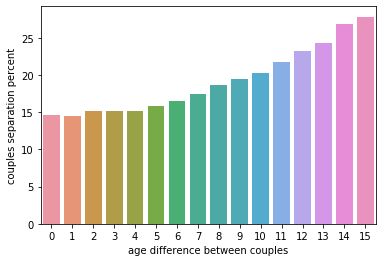

In [293]:
ax = sns.barplot(x="age_diff", y="percent", data=age_diff_separation_stats, )
ax.set(xlabel='age difference between couples', ylabel='couples separation percent')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_age_diff_separation_percentages")

In [306]:
couples_df_found.dtypes

county_code_L               object
voter_id_L                   int64
last_name_L                 object
first_name_L                object
residence_addr_line_1_L     object
residence_addr_line_2_L     object
residence_city_L            object
residence_zipcode_L          int64
gender_L                    object
race_L                     float64
birth_date_L                object
registration_date_L         object
party_affiliation_L         object
precinct_L                  object
voter_status_L              object
age_L                        int64
residence_zipcode_5_L        int64
residence_zipcode_4_L      float64
uniq_addr                   object
county_code_R               object
voter_id_R                   int64
last_name_R                 object
first_name_R                object
residence_addr_line_1_R     object
residence_addr_line_2_R     object
residence_city_R            object
residence_zipcode_R          int64
gender_R                    object
race_R              

In [308]:
df = couples_df_found[['Latitude', 'Latitude_R','Longitude','Longitude_R', 'race_L', 'race_R', 'separated']]

In [315]:
#df.shape
df = df.dropna()

(1687551, 7)

In [ ]:

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df)
train_cluster['tsne-X'] = tsne_results[:,0]
train_cluster['tsne-Y'] = tsne_results[:,1]

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-X", y="tsne-Y",
    hue="cluster",
    palette=sns.color_palette("hls", 15),
    data=train_cluster,
    legend="full",
    alpha=0.3
)

In [296]:
# cf_polarized_all = np.where(((couples_df_found["party_affiliation_L"] == "DEM") & (couples_df_found["party_affiliation_R"] == "DEM"))
#                             | ((couples_df_found["party_affiliation_L"] == "REP") & (couples_df_found["party_affiliation_R"] == "REP"))
#                             | ((couples_df_found["party_affiliation_L"] == "NPA") & (couples_df_found["party_affiliation_R"] == "NPA"))
#                         , 0, 1) 

In [297]:
#pearson_corr, corr_pvalue = stats.pearsonr(cf_polarized_all, cf_separated)
#print('Correlation of Polarized couples Vs their separation rate: {} \nP_value: {}'.format(pearson_corr, corr_pvalue))

In [298]:
#couples_df_stat = pd.read_csv("stats/20160307_20180313/party_affiliation_totalCouples-2709111.csv" , sep='\t')

In [299]:
#couples_df_stat.columns = ["no", "separation_percent","cat_comb","total","cat_comb_percent"]

In [300]:
#couples_df_stat["no"]

In [301]:
from sklearn.metrics import jaccard_score

In [302]:
#couples_df_n = pd.merge(couples_df, fla_lat, left_on="uniq_addr", right_on = "uniq_addr_2",)

In [118]:
#couples_df_n.isnull().sum()

county_code_L                    0
voter_id_L                       0
last_name_L                     32
first_name_L                    99
residence_addr_line_1_L          0
residence_addr_line_2_L    2626663
residence_city_L                 0
residence_zipcode_L              0
gender_L                         0
race_L                          48
birth_date_L                     0
registration_date_L              0
party_affiliation_L              0
precinct_L                       0
voter_status_L                   0
age_L                            0
residence_zipcode_5_L            0
residence_zipcode_4_L      2637109
uniq_addr                        0
county_code_R                    0
voter_id_R                       0
last_name_R                     38
first_name_R                   127
residence_addr_line_1_R          0
residence_addr_line_2_R    2626661
residence_city_R                 0
residence_zipcode_R              0
gender_R                         0
race_R              

In [157]:
jaccard_similarity(tokenized_row_L, tokenized_row_R)

TypeError: unhashable type: 'list'

In [154]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [156]:
tokenized_row_L = [d.split() for d in couples_df_found['uniq_addr_L']]
tokenized_row_R = [d.split() for d in couples_df_found['uniq_addr_R']]


In [74]:
from scipy.stats import chi2_contingency
#print(chi2_contingency(pd.crosstab(cf_polarized_all, cf_separated)))

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#cramers_corrected_stat(pd.crosstab(cf_polarized_all, cf_separated))